In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from shapely import wkt
import matplotlib.pyplot as plt
import random
import rasterio.features
import rasterio.transform
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import cv2

In [15]:
polygon_df = pd.read_csv('../raw/all_polygons_with_climate_variables.csv')

In [16]:
def convert_to_polygon(wkt_string):
    try:
        return wkt.loads(wkt_string)
    except Exception as e:
        print(f"Error parsing WKT: {e}")
        return None

def multi_to_single_poly(multipoly):
    if isinstance(multipoly, MultiPolygon):
        return max(multipoly.geoms, key=lambda x: x.area)
    else:
        return multipoly

In [17]:
polygon_df.geometry = polygon_df.geometry.apply(convert_to_polygon)
polygon_df.geometry = polygon_df.geometry.apply(multi_to_single_poly)

In [18]:
polygon_df.columns

Index(['DOY', 'YYYYMMDD', 'YEAR', 'geometry', 'FIRE_NAME', 'CENTROID_LAT',
       'CENTROID_LON', 'MONTH', 'DAY', 'precipitation_amount',
       'burning_index_g', 'potential_evapotranspiration_alfalfa',
       'potential_evapotranspiration_short_grass', 'dead_fuel_moisture_100hr',
       'dead_fuel_moisture_1000hr', 'relative_humidity_maximum',
       'relative_humidity_minimum', 'specific_humidity', 'wind_from_direction',
       'air_temperature_minimum', 'air_temperature_maximum',
       'mean_vapor_pressure_deficit', 'wind_speed'],
      dtype='object')

In [19]:
polygon_df.drop(columns=['DOY', 'YYYYMMDD', 'YEAR', 'CENTROID_LAT', 'CENTROID_LON', 'MONTH', 'DAY']).describe()

,precipitation_amount,burning_index_g,potential_evapotranspiration_alfalfa,potential_evapotranspiration_short_grass,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,relative_humidity_maximum,relative_humidity_minimum,specific_humidity,wind_from_direction,air_temperature_minimum,air_temperature_maximum,mean_vapor_pressure_deficit,wind_speed
count,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5.848000e+03,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000
mean,0.019872,56.838748,0.744195,0.543507,0.677202,0.747683,5.023222,1.777173,5.216601e-08,200.296341,238.458362,249.951038,0.017988,0.303524
std,0.172403,15.806017,0.221552,0.156438,0.206775,0.176406,1.781112,0.948092,2.076664e-08,89.273132,0.536647,0.607301,0.006937,0.119280
min,0.000000,0.000000,0.060000,0.060000,0.250000,0.370000,1.110000,0.100000,4.900000e-09,0.000000,236.140000,247.290000,0.000000,0.060000
25%,0.000000,50.000000,0.610000,0.450000,0.530000,0.610000,3.710000,1.090000,3.600000e-08,142.000000,238.130000,249.590000,0.013200,0.230000
50%,0.000000,58.000000,0.740000,0.550000,0.640000,0.740000,4.770000,1.660000,5.250000e-08,208.000000,238.490000,249.980000,0.017100,0.280000
75%,0.000000,66.000000,0.880000,0.650000,0.780000,0.840000,6.140000,2.310000,6.780000e-08,267.000000,238.830000,250.390000,0.022200,0.350000
max,4.210000,131.000000,2.050000,1.330000,1.940000,2.570000,10.000000,8.990000,1.409000e-07,360.000000,240.140000,251.710000,0.050600,1.090000


In [20]:
polygon_df = polygon_df.rename(columns={"precipitation_amount": "precipitation",
                                        "burning_index_g": "burning_index",
                                        "potential_evapotranspiration_alfalfa": "evapotranspiration_al",
                                        "potential_evapotranspiration_short_grass": "evapotranspiration_sg",
                                        "dead_fuel_moisture_100hr": "fuel_moisture_100",
                                        "dead_fuel_moisture_1000hr": "fuel_moisture_1000",
                                        "relative_humidity_maximum": "relative_humidity_max",
                                        "relative_humidity_minimum": "relative_humidity_min",
                                        "air_temperature_minimum": "temperature_min",
                                        "air_temperature_maximum": "temperature_max",
                                        "mean_vapor_pressure_deficit": "vpd",
                                        "CENTROID_LAT": "latitude",
                                        "CENTROID_LON": "longitude"
                                        })

In [21]:
polygon_df = polygon_df.drop(columns=["evapotranspiration_sg", "fuel_moisture_100", "relative_humidity_min", "temperature_min", "wind_from_direction", "precipitation", "DOY", "YEAR", "MONTH", "DAY"])

In [22]:
polygon_df

,YYYYMMDD,geometry,FIRE_NAME,latitude,longitude,burning_index,evapotranspiration_al,fuel_moisture_1000,relative_humidity_max,specific_humidity,temperature_max,vpd,wind_speed
0,2012-07-12,POLYGON ((-123.33477800000003 40.7968479999999...,FLAT,40.790442,-123.335819,54.0,1.08,0.95,6.50,7.770000e-08,250.99,0.0270,0.29
1,2012-07-13,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792111,-123.336071,59.0,1.15,0.94,7.20,8.030000e-08,250.97,0.0258,0.36
2,2012-07-14,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792633,-123.334991,60.0,1.14,0.92,5.99,7.500000e-08,250.85,0.0254,0.36
3,2012-07-15,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792755,-123.332730,66.0,1.25,0.91,6.48,7.920000e-08,250.89,0.0253,0.45
4,2012-07-16,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792319,-123.331770,57.0,1.00,0.90,6.26,6.260000e-08,250.55,0.0212,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,2017-08-21,"POLYGON ((-118.30777 36.25553099999997, -118.3...",INDIAN,36.247429,-118.295438,79.0,0.81,0.72,5.79,5.660000e-08,249.44,0.0114,0.57
5844,2020-10-27,POLYGON ((-120.49860400000004 39.0017319999999...,POINT,39.002256,-120.486900,93.0,0.73,0.57,3.92,2.300000e-08,249.23,0.0123,0.55
5845,2020-10-28,POLYGON ((-120.49860400000001 39.0017319999999...,POINT,39.002801,-120.487869,72.0,0.55,0.56,2.20,1.280000e-08,249.58,0.0171,0.26
5846,2013-08-09,"POLYGON ((-117.614136 34.34099200000007, -117....",SHARP,34.337601,-117.616687,75.0,0.88,0.61,4.28,3.160000e-08,249.76,0.0164,0.36


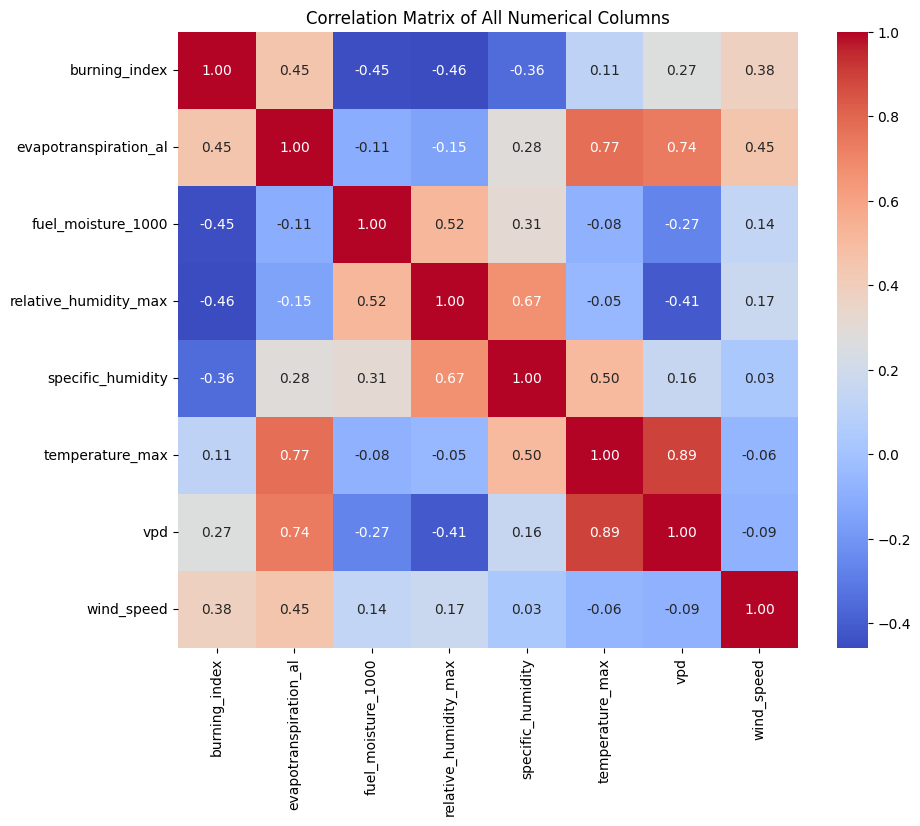

In [ ]:
import seaborn as sns

correlation_matrix = polygon_df.drop(columns=["YYYYMMDD", "geometry", "FIRE_NAME", "latitude", "longitude"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix of All Numerical Columns')
plt.show()

In [28]:
polygon_df

,YYYYMMDD,geometry,FIRE_NAME,latitude,longitude,burning_index,evapotranspiration_al,fuel_moisture_1000,relative_humidity_max,specific_humidity,temperature_max,vpd,wind_speed
0,2012-07-12,POLYGON ((-123.33477800000003 40.7968479999999...,FLAT,40.790442,-123.335819,54.0,1.08,0.95,6.50,7.770000e-08,250.99,0.0270,0.29
1,2012-07-13,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792111,-123.336071,59.0,1.15,0.94,7.20,8.030000e-08,250.97,0.0258,0.36
2,2012-07-14,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792633,-123.334991,60.0,1.14,0.92,5.99,7.500000e-08,250.85,0.0254,0.36
3,2012-07-15,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792755,-123.332730,66.0,1.25,0.91,6.48,7.920000e-08,250.89,0.0253,0.45
4,2012-07-16,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792319,-123.331770,57.0,1.00,0.90,6.26,6.260000e-08,250.55,0.0212,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,2017-08-21,"POLYGON ((-118.30777 36.25553099999997, -118.3...",INDIAN,36.247429,-118.295438,79.0,0.81,0.72,5.79,5.660000e-08,249.44,0.0114,0.57
5844,2020-10-27,POLYGON ((-120.49860400000004 39.0017319999999...,POINT,39.002256,-120.486900,93.0,0.73,0.57,3.92,2.300000e-08,249.23,0.0123,0.55
5845,2020-10-28,POLYGON ((-120.49860400000001 39.0017319999999...,POINT,39.002801,-120.487869,72.0,0.55,0.56,2.20,1.280000e-08,249.58,0.0171,0.26
5846,2013-08-09,"POLYGON ((-117.614136 34.34099200000007, -117....",SHARP,34.337601,-117.616687,75.0,0.88,0.61,4.28,3.160000e-08,249.76,0.0164,0.36


In [29]:
polygon_df.to_csv("../dataset.csv")